In [262]:

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import bootstrap

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

df = pd.read_csv("results/all_data.csv")


In [270]:
set(range(144)) - set(df[df['Model Pair'] == 'Claude_Sonnet_4-Claude_Sonnet_4']['Grid ID'].unique())

{15,
 16,
 17,
 18,
 19,
 20,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 75,
 76,
 77,
 78,
 79,
 80,
 103}

In [263]:
df = df.sort_values(by=['Model Pair', 'Grid ID', 'Config ID', 'Total Score'], ascending=[True, True, True, False])

In [264]:
df = df.drop_duplicates(subset=['Model Pair', 'Grid ID', 'Config ID'], keep='first')


In [265]:
df[['Model Pair','Run ID']].groupby(['Model Pair']).count()

,Run ID
Model Pair,
Claude_Sonnet_4-Claude_Sonnet_4,577
DeepSeek_R1-DeepSeek_R1,715
GPT_4.1-GPT_4.1,1605
Llama_405B-Llama_405B,668



## Completion and Scoring Metrics
Zero sum game when they finish so maybe total points and accuracy aren't that interesting, as they're really just describing the following metrics which we care about:
- both players finished vs baseline
- both players meet baseline score
- (for needy and MD): both players beat baseline
    - per player beat baseline

## Trade Level Metrics and Questions
- relationship between trade acceptance rate and both players finished

## P4P
- Total P4P Promises Broken

## Contract level
- Relationship between contract agreed and both complete or number complete
    This could be a heatmap, grouped barchart or mosaic map (agreed vs not and completion vs not (or number completions))
- Relationship between num points swapped for completion and number complete

In [272]:

mapping = {'ctx1_fog00_p4pfalse_contract_contract_for_finishing': 'contract_for_finishing',
       'ctx1_fog00_p4pfalse_contract_none': 'regular_trading',
       'ctx1_fog00_p4pfalse_contract_strict': 'strict_tile_contracts',
       'ctx1_fog00_p4pfalse_contract_tile_with_judge_implementation': 'tile_contract_with_llm_implementation',
       'ctx1_fog00_p4ptrue_contract_none': 'p4p'
}
df['game_type'] = df['Config ID'].map(mapping)

df['Non-Cooperative Baseline Player R'] = df['Non-Cooperative Baseline Player 0']
df['Non-Cooperative Baseline Player B'] = df['Non-Cooperative Baseline Player 1']
df['Score Player R'] = df['Score Player 0']
df['Score Player B'] = df['Score Player 1']
df['R_achieves_baseline'] = df['Score Player 0'] >= df['Non-Cooperative Baseline Player 0']
df['B_achieves_baseline'] = df['Score Player 1'] >= df['Non-Cooperative Baseline Player 1']
df['Reached Goal Player R'] = df['Reached Goal Player 0']
df['Reached Goal Player B'] = df['Reached Goal Player 1']
df['both_achieve_baseline'] = df['R_achieves_baseline'] & df['B_achieves_baseline']
df['R_beats_baseline'] = df['Score Player R'] > df['Non-Cooperative Baseline Player 0']
df['B_beats_baseline'] = df['Score Player B'] > df['Non-Cooperative Baseline Player 1']
df['both_beat_baseline'] = (df['R_beats_baseline']) & (df['B_beats_baseline'])
df['both_finished'] = (df['Reached Goal Player 0'] > 0) & (df['Reached Goal Player 1'] > 0)
df['either_finished'] = (df['Reached Goal Player 0'] > 0) | (df['Reached Goal Player 1'] > 0)
df['both_finished_and_achieve_baseline'] = (df['both_finished']) & (df['both_achieve_baseline'])
df['both_finished_and_beat_baseline'] = (df['both_finished']) & (df['both_beat_baseline'])
df['p4p_honor_rate'] = 1 - (df['Total P4P Promises Broken'] / (df['Total P4P Promises Kept'] + df['Total P4P Promises Broken'])).replace([np.inf, -np.inf], np.nan)

desired_order = ['regular_trading', 'p4p', 'contract_for_finishing', 'strict_tile_contracts', 'tile_contract_with_llm_implementation']
df['game_type'] = pd.Categorical(df['game_type'], categories=desired_order, ordered=True)


In [291]:
def calculate_bootstrap_ci(data, n_resamples=1000, confidence_level=0.68):
    """
    Calculate bootstrap confidence intervals for the mean.
    """
    if len(data) == 0:
        return (np.nan, np.nan)  # Return NaN if no data is available

    # Use scipy.stats.bootstrap to calculate the confidence interval
    res = bootstrap((data,), np.mean, confidence_level=confidence_level, n_resamples=n_resamples, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high


In [295]:

def plot_metrics(df, column, for_loop='Model Pair', legend= 'game_type', x_axis='Bucket',
                 specific_model_pairs=None,
                 specific_game_types=None,
                 specific_buckets=None):
    
    # Ensure the data has the required columns
    required_columns = ['game_type', 'Model Pair', 'Bucket'] + [column]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    for_loop_values = df[for_loop].unique()

    for iterable in for_loop_values:
        filtered_df = df[df[for_loop] == iterable].copy()
        if specific_buckets is not None:
            filtered_df = filtered_df[filtered_df['Bucket'].isin(specific_buckets)]
        if specific_model_pairs is not None:
            filtered_df = filtered_df[filtered_df['Model Pair'].isin(specific_model_pairs)]
        if specific_game_types is not None:
            filtered_df = filtered_df[filtered_df['game_type'].isin(specific_game_types)]
            filtered_df['game_type'] = filtered_df['game_type'].cat.remove_unused_categories()
        if filtered_df.empty:
            continue
        grouped = filtered_df.groupby([x_axis, legend], observed=True).agg(
                grouped_col_mean=(column, 'mean'),
                grouped_col_count=(column, 'count'), # count of values for each bar
            ).reset_index()
        grouped[f'{column}_ci'] = grouped.apply(
            lambda row: calculate_bootstrap_ci(
                filtered_df[
                    (filtered_df[x_axis] == row[x_axis]) &
                    (filtered_df[legend] == row[legend])
                ][column]
            ),
            axis=1
        )

        grouped[f'{column}_lower'] = grouped[f'{column}_ci'].apply(lambda x: x[0])
        grouped[f'{column}_upper'] = grouped[f'{column}_ci'].apply(lambda x: x[1])
        grouped[f'{column}_err_lower'] = grouped['grouped_col_mean'] - grouped[f'{column}_lower']
        grouped[f'{column}_err_upper'] = grouped[f'{column}_upper'] - grouped['grouped_col_mean']
        plt.figure(figsize=(12, 8))

        ax = sns.barplot(
            data=grouped,
            x=x_axis,
            y='grouped_col_mean',
            hue=legend,
            palette='Set2',
            errorbar=None
        )

        # Loop over the containers (one per hue/category)
        # Loop over containers (one per hue)
        # Loop over the containers (one per hue/category)
        for container, legend_value in zip(ax.containers, grouped[legend].unique()):
            # Get the rows corresponding to this bucket
            legend_value_rows = grouped[grouped[legend] == legend_value].sort_values('game_type')
            
            for bar, (_, row) in zip(container, legend_value_rows.iterrows()):
                x = bar.get_x() + bar.get_width() / 2  # Center of the bar
                yerr = [[row['grouped_col_mean'] - row[f'{column}_lower']], 
                        [row[f'{column}_upper'] - row['grouped_col_mean']]]
                plt.errorbar(
                    x=x,
                    y=row['grouped_col_mean'],
                    yerr=yerr,
                    fmt='none',
                    color='black',
                    capsize=5
                )
                y = row['grouped_col_mean']                
                    # Add count on top of the bar
                plt.text(
                    x=x + bar.get_width() / 3,
                    y=y + (row[f'grouped_col_mean'] - y) + 0.01,  # slightly above the error bar
                    s= f'n: {str(row['grouped_col_count'])}',
                    ha='center',
                    va='bottom',
                    fontsize=10
                )

        plt.title(f'{column} Across Game Types ({for_loop}: {iterable})')
        plt.xlabel(x_axis)
        plt.ylabel(column)
        plt.legend(title=legend, loc='lower left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


        

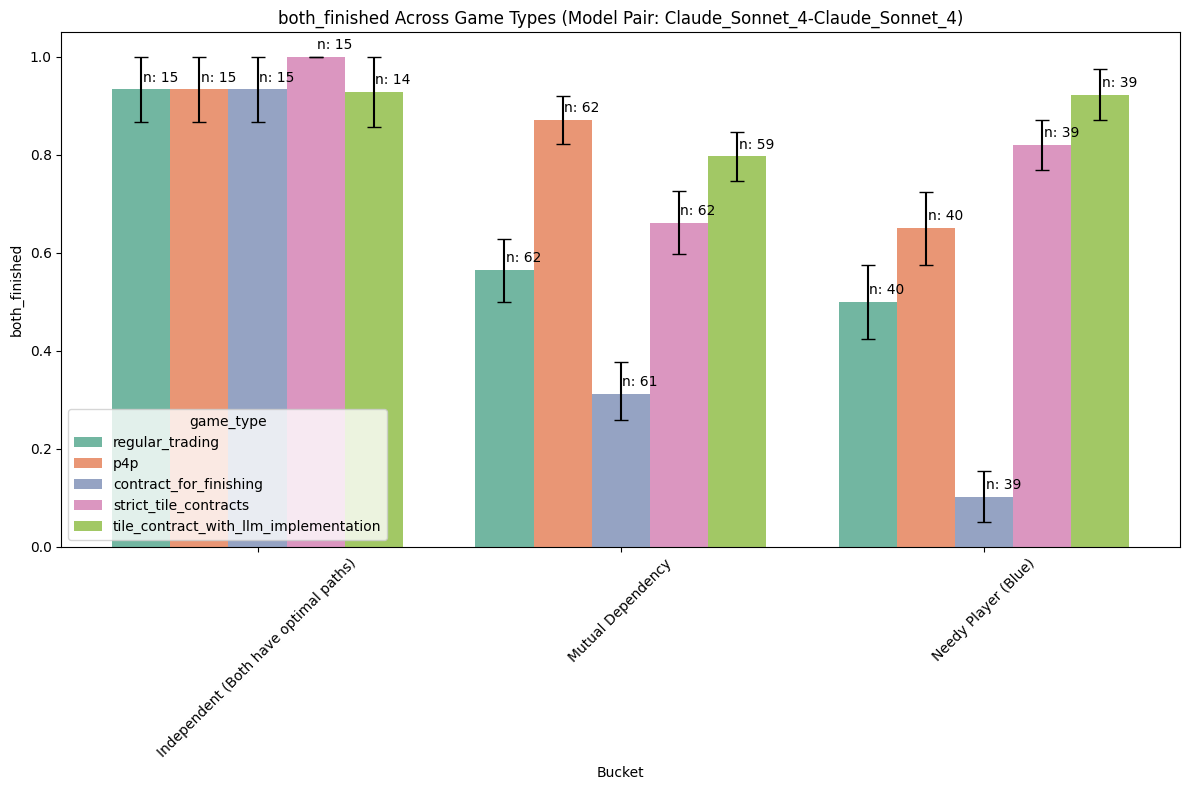

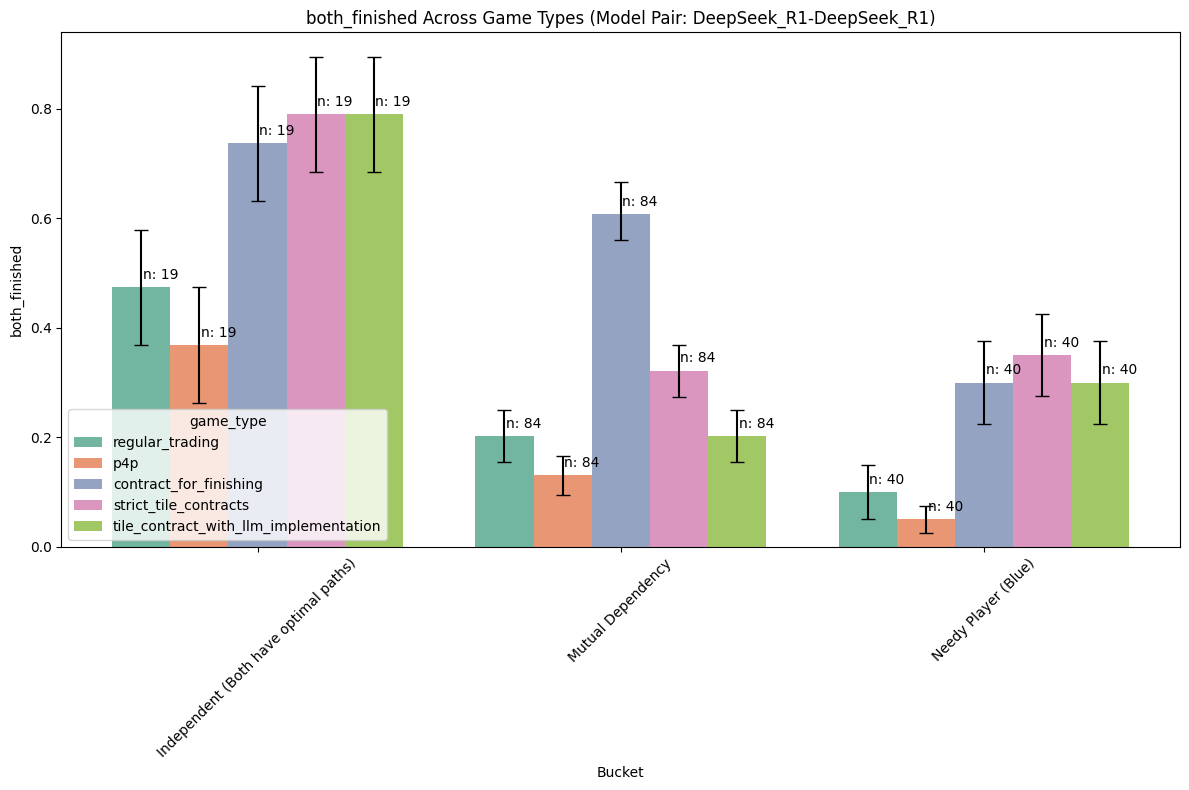

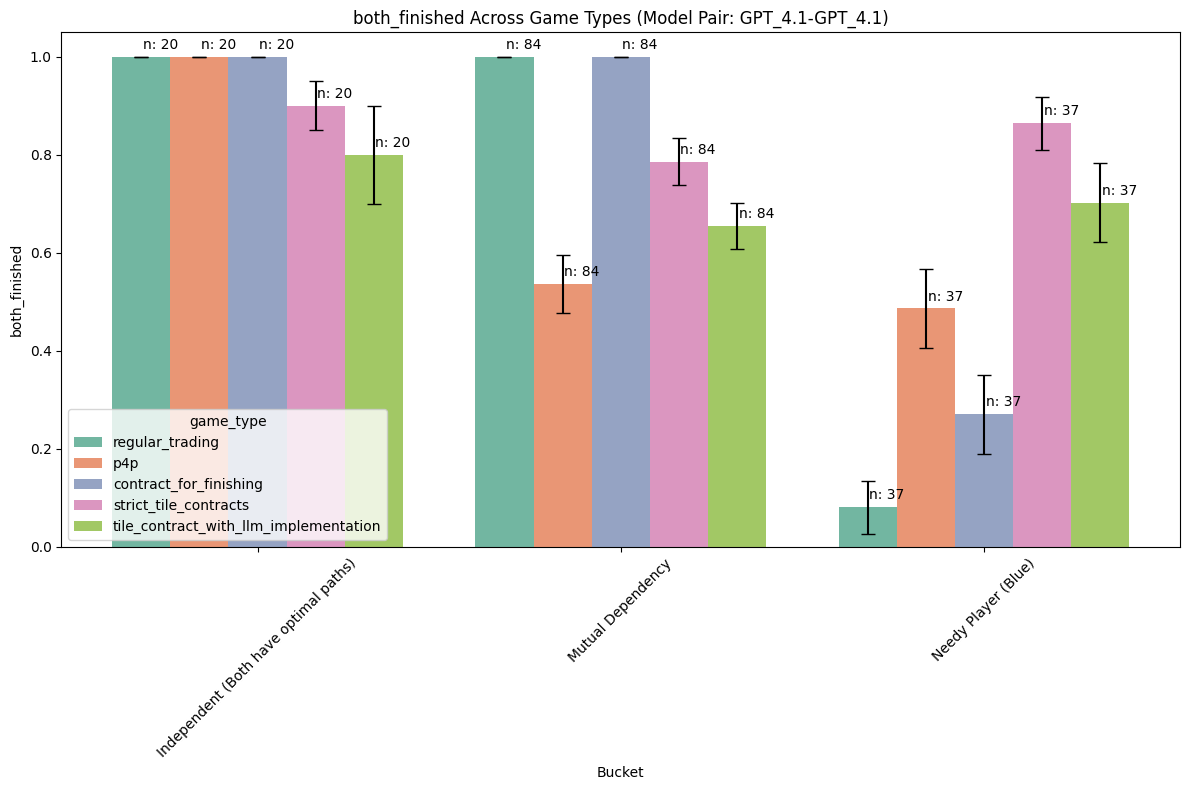

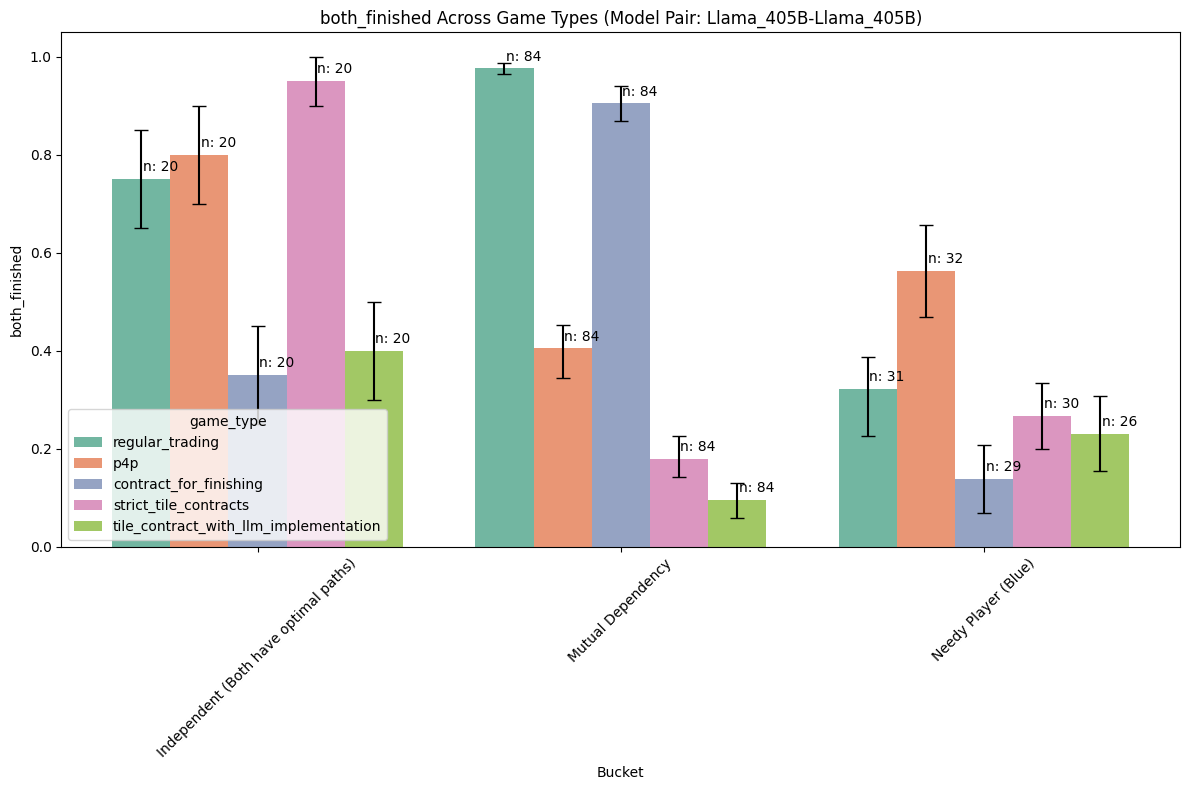

In [296]:
plot_metrics(df, 'both_finished', legend='game_type', x_axis='Bucket')

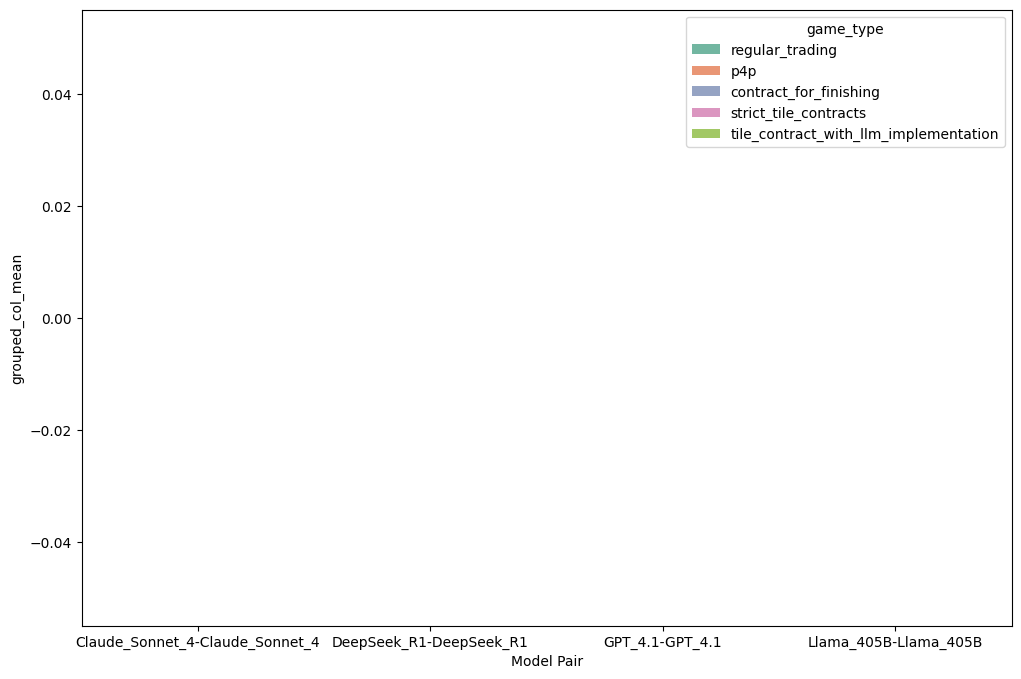

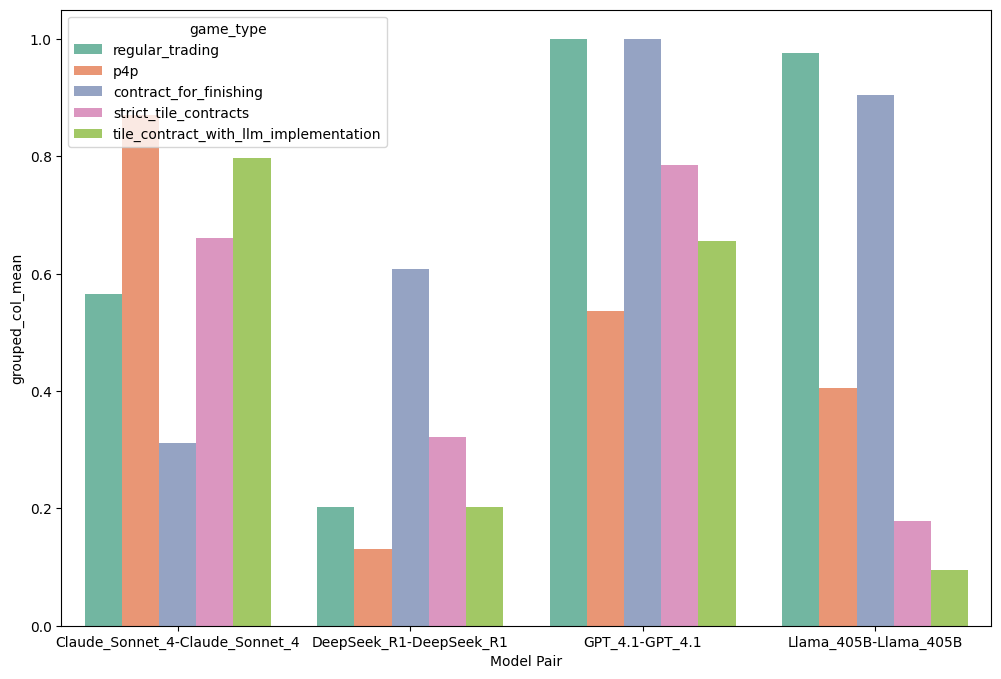

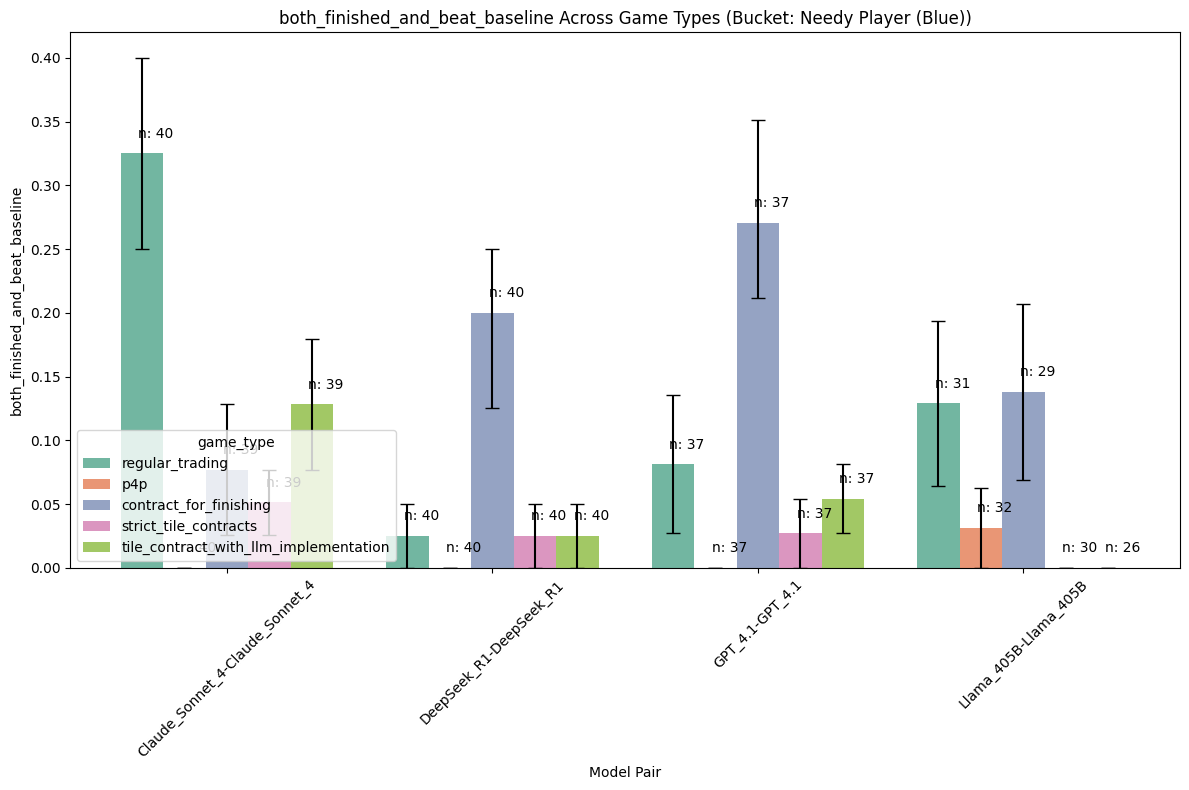

In [294]:
plot_metrics(df, 'both_finished_and_beat_baseline', for_loop='Bucket', legend='game_type', x_axis='Model Pair')

['contract_for_finishing', 'regular_trading']
Categories (2, object): ['regular_trading' < 'contract_for_finishing']


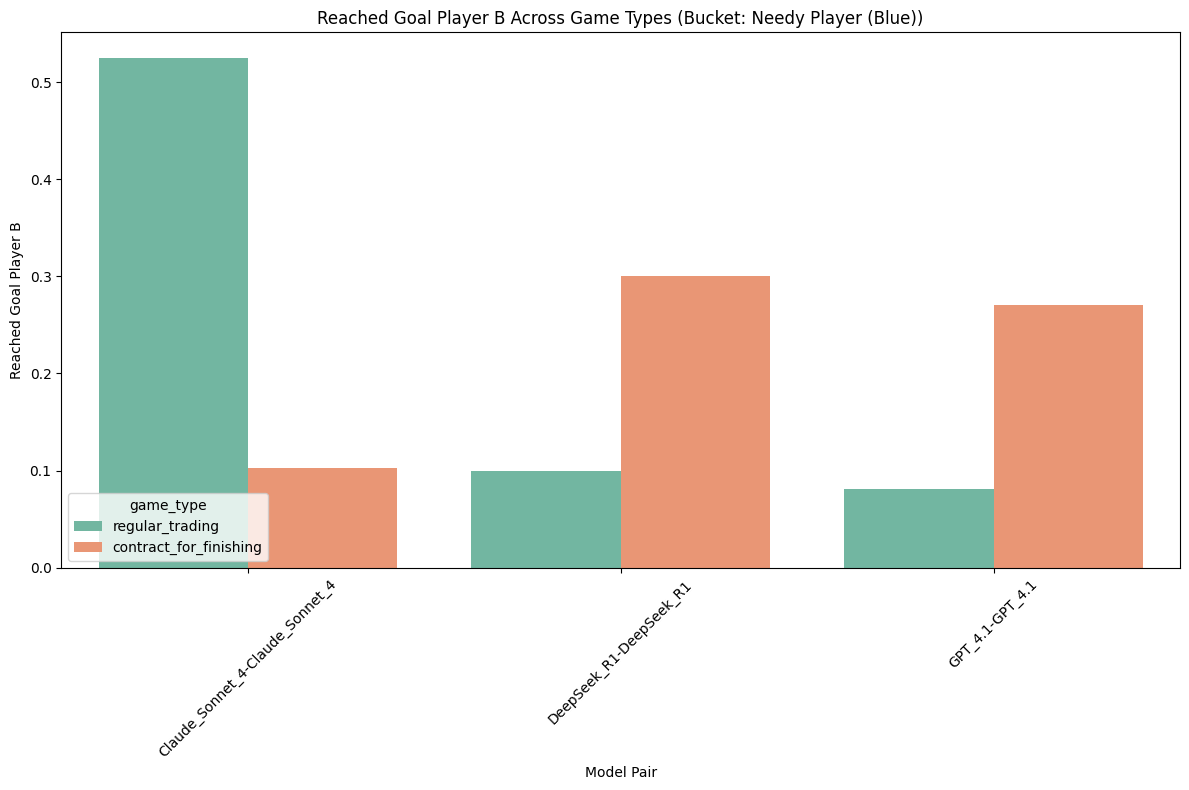

In [211]:
plot_metrics(df, 'Reached Goal Player B', for_loop='Bucket', legend= 'game_type', x_axis='Model Pair',
                 specific_model_pairs=None,
                 specific_game_types=['regular_trading', 'contract_for_finishing'],
                 specific_buckets=['Needy Player (Blue)'])

['contract_for_finishing', 'regular_trading']
Categories (2, object): ['regular_trading' < 'contract_for_finishing']


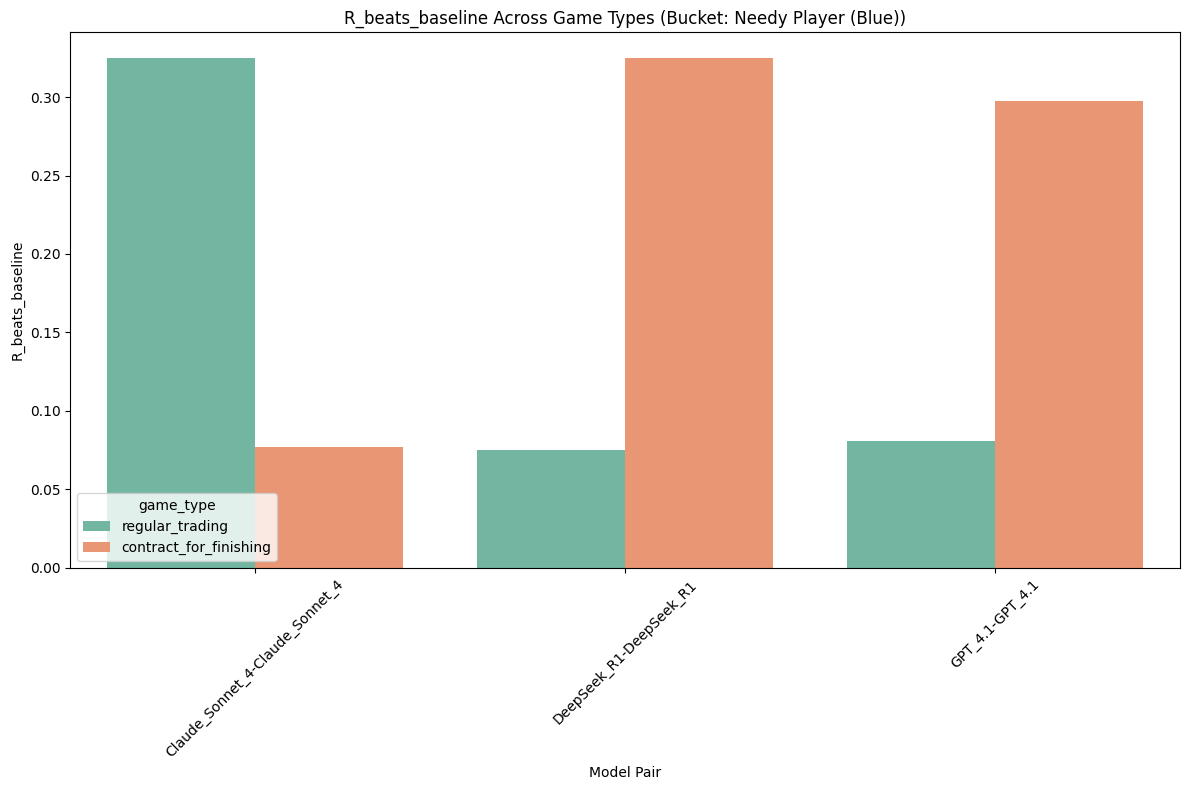

In [212]:
plot_metrics(df, 'R_beats_baseline', for_loop='Bucket', legend= 'game_type', x_axis='Model Pair',
                 specific_model_pairs=None,
                 specific_game_types=['regular_trading', 'contract_for_finishing'],
                 specific_buckets=['Needy Player (Blue)'])

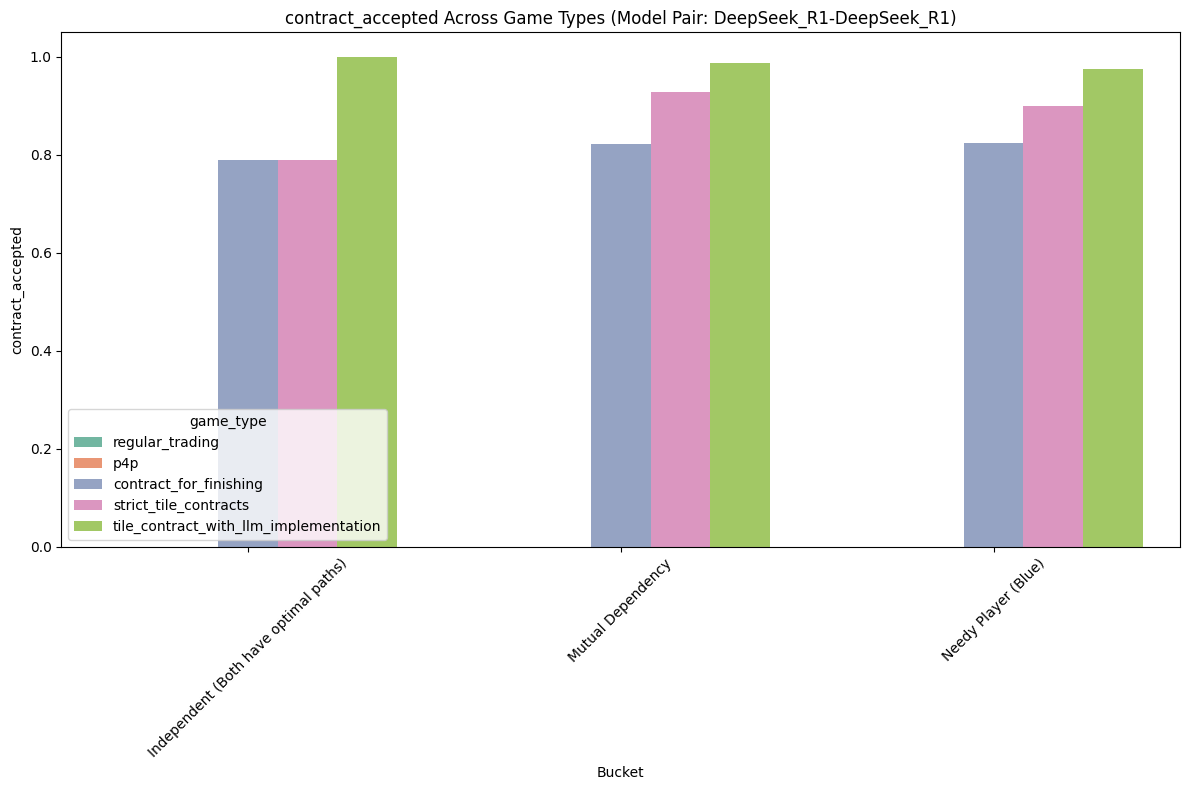

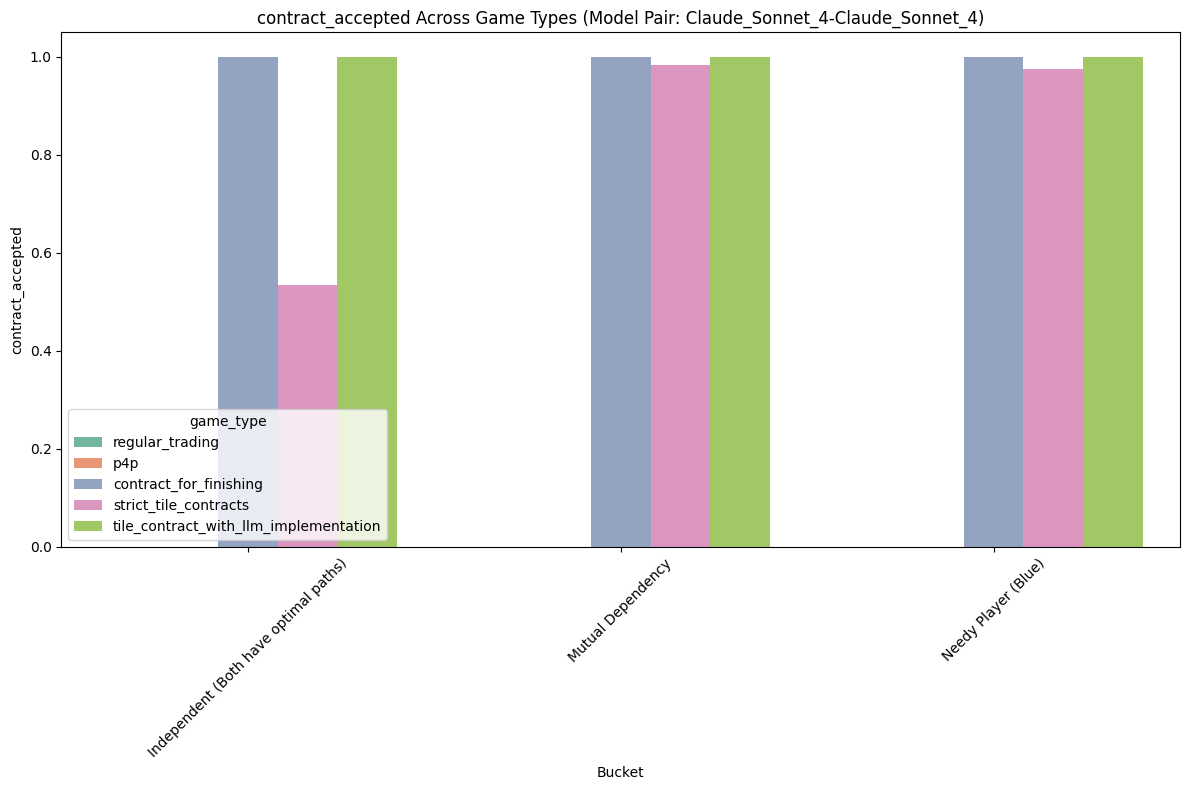

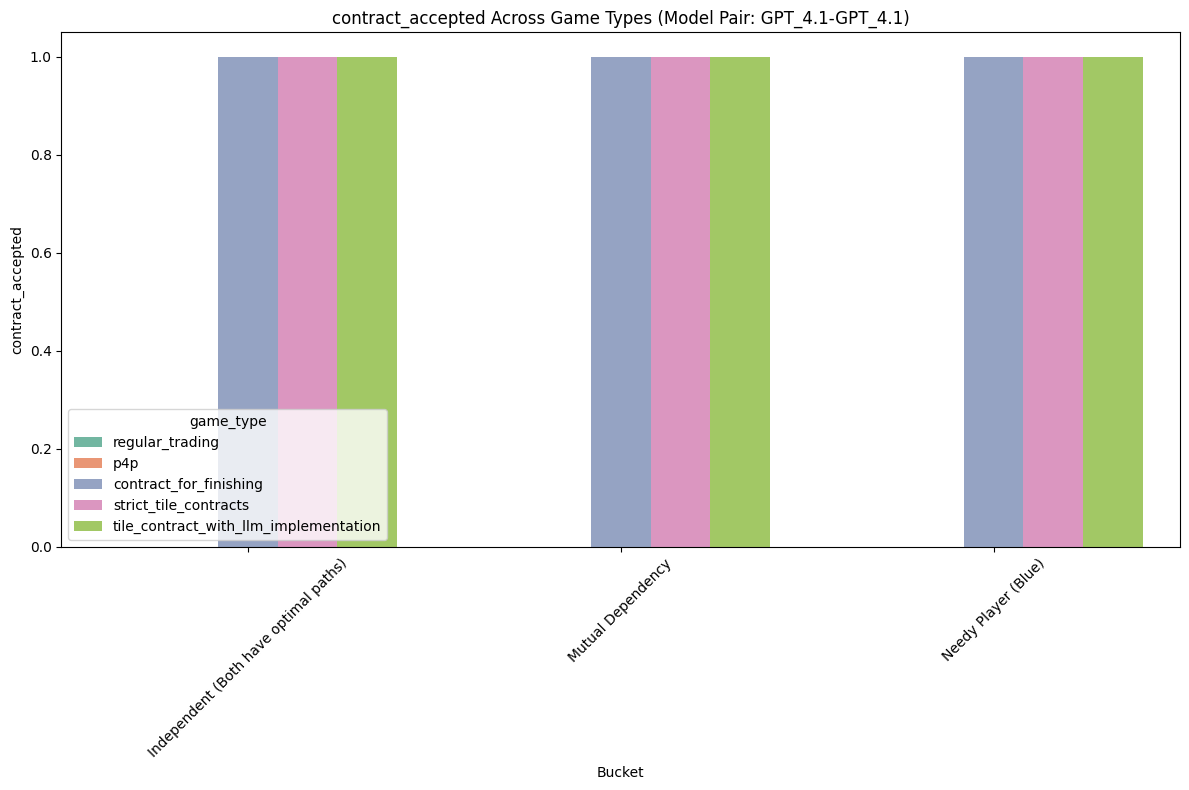

In [215]:
plot_metrics(df, 'contract_accepted')

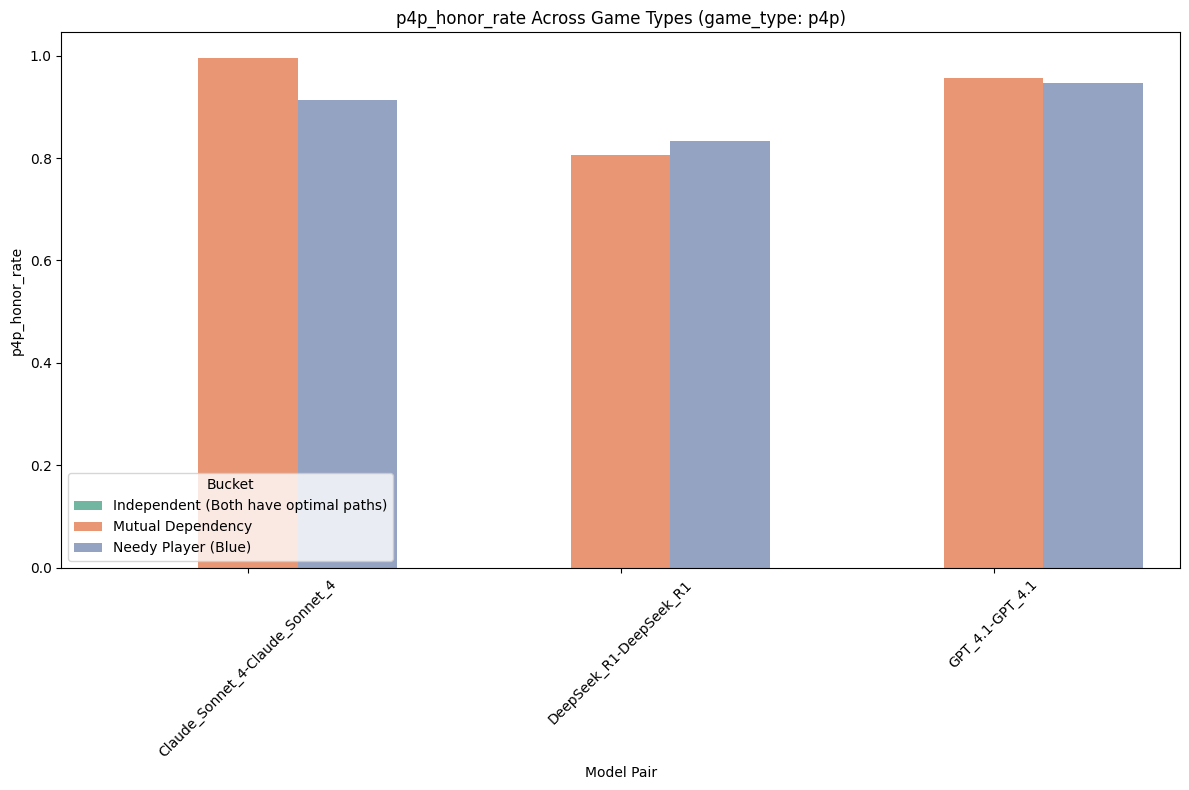

In [225]:
plot_metrics(df, 'p4p_honor_rate', for_loop='game_type', legend= 'Bucket', x_axis='Model Pair', specific_game_types=['p4p'])

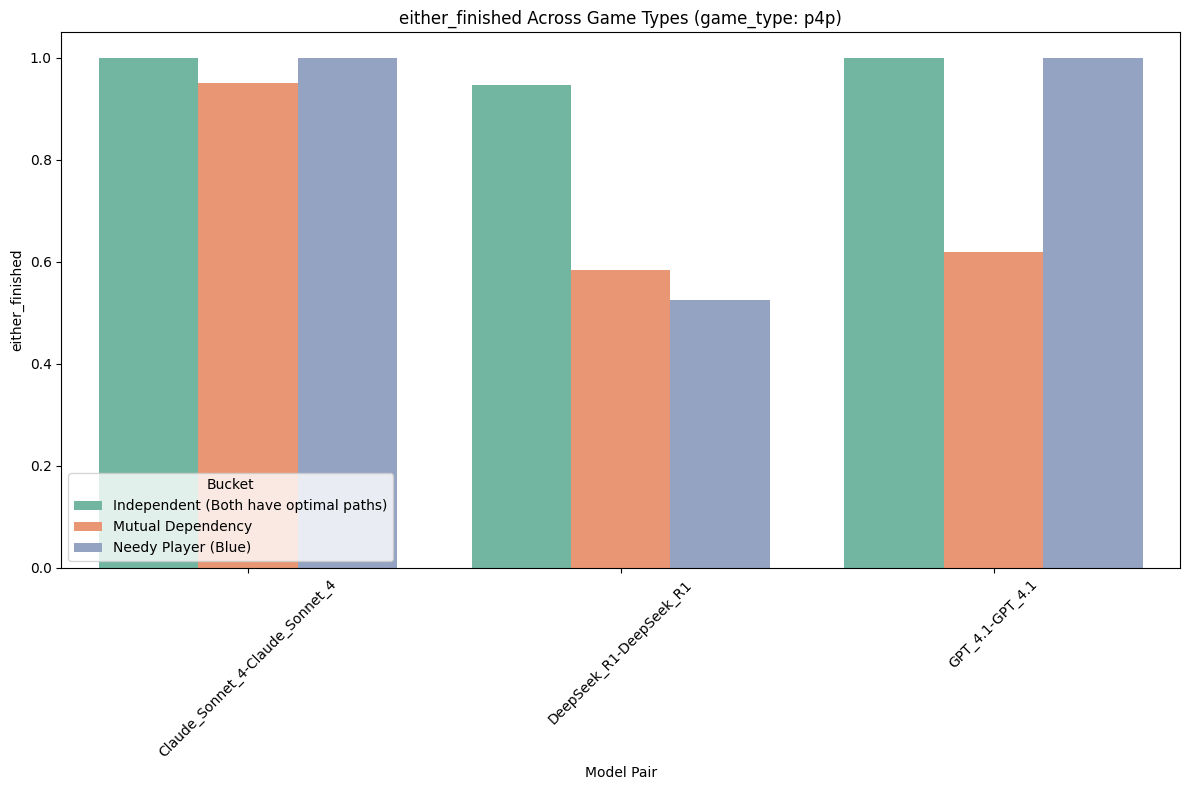

In [221]:
plot_metrics(df, 'either_finished', for_loop='game_type', legend= 'Bucket', x_axis='Model Pair', specific_game_types=['p4p'])